In [ ]:
# # Uninstall the current Gym version
!pip uninstall -y gym

# # Install Gym version 0.23.1
!pip install gym==0.23.1

# # Restart the runtime after installation (necessary in some environments like Colab)
import os
os._exit(00)


Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701372 sha256=dc12282434a757c5b087b0815af14cf584848ad48c82fa0b921c3f42d96a4b7c
  Stored in directory: /root/.cache/pip/wheels/1a/00/fb/fe5cf2860fb9b7bc860e28f00095a1f42c7b726dd6f42d1acc
Successfully built gym


In [1]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1488/1488), done.
remote: Compressing objects: 100% (373/373), done.
remote: Total 13187 (delta 1166), reused 1220 (delta 1100), pack-reused 11699 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 14.05 MiB/s, done.
Resolving deltas: 100% (9972/9972), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
  Running setup.py develop for neurogym


In [2]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

In [3]:
# Make a LSTM, input_size is the dimension of inputs,
# hidden_size is the number of hidden neurons
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2)

# Generate some mock inputs
input = torch.randn(5, 3, 10)  # The arguments represent (Sequence Length, Batch Size, Input Size). Typically, in neuroscience,
# sequence length would correspond to time points in the time series, Batch size corresponds to the number of trials and
# input size corresponds to the dimension of the input (ie., the number of neurons or channels you're collecting data from)
output, (hn, cn) = rnn(input)

print('Output shape is (SeqLen, BatchSize, HiddenSize):', output.shape)



Output shape is (SeqLen, BatchSize, HiddenSize): torch.Size([5, 3, 20])


In [4]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.input_size = input_size
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

In [5]:
class LeakyRNN_sparse(nn.Module):
    """Leaky RNN with optional sparsity.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: Discretization time step in ms.
            If None, dt equals time constant tau
        sparsity: Fraction of weights to set to zero (default: 0, no sparsity)

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, sparsity=0.2,):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        self.sparsity = sparsity

        # Define alpha based on dt and tau
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        # Define input and recurrent layers
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

        # Create and apply sparsity mask if sparsity > 0
        if self.sparsity > 0:
            self.sparsity_mask = (torch.rand(hidden_size, hidden_size) >= sparsity).float()
            self.h2h.weight.data *= self.sparsity_mask  # Apply the mask to initial weights

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = F.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propagate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet_sparse(nn.Module):
    """Recurrent network model with optional sparsity.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        sparsity: float, fraction of recurrent weights set to zero

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, sparsity=0.0, **kwargs):
        super().__init__()

        # Leaky RNN with sparsity
        self.input_size = input_size
        self.rnn = LeakyRNN_sparse(input_size, hidden_size, sparsity=sparsity, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output_sparse, _ = self.rnn(x)
        out_sparse = self.fc(rnn_output_sparse)
        return out_sparse, rnn_output_sparse


In [44]:
class LeakyRNN_dale(nn.Module):
    def __init__(self, input_size, hidden_size, dt=None, exc_inh_ratio=0.8):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        self.exc_inh_ratio = exc_inh_ratio

        # Number of excitatory and inhibitory neurons
        self.num_exc_neurons = int(self.hidden_size * self.exc_inh_ratio)
        self.num_inh_neurons = self.hidden_size - self.num_exc_neurons

        # Leaky integration parameter
        self.alpha = dt / self.tau if dt else 1.0

        # Linear transformations
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        # Compute excitatory and inhibitory parts
        h_exc = hidden[:, :self.num_exc_neurons]
        h_inh = hidden[:, self.num_exc_neurons:]

        # Input to hidden transformation
        h_input = self.input2h(input)

        # Apply h2h transformation
        h_h2h = self.h2h(hidden)

        # Update excitatory and inhibitory neurons separately
        h_exc_new = F.relu(h_input[:, :self.num_exc_neurons] + h_h2h[:, :self.num_exc_neurons])
        h_inh_new = F.tanh(h_input[:, self.num_exc_neurons:] + h_h2h[:, self.num_exc_neurons:])

        # Concatenate and apply leaky integration
        h_new = torch.cat((h_exc_new, h_inh_new), dim=1)
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input.shape[1]).to(input.device)

        output = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet_dale(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dt=None, exc_inh_ratio=0.8):
        super().__init__()
        # Leaky RNN with separate excitatory/inhibitory neurons
        self.input_size = input_size
        self.rnn = LeakyRNN_dale(input_size, hidden_size, dt=dt, exc_inh_ratio=exc_inh_ratio)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output_dale, _ = self.rnn(x)
        out_dale = self.fc(rnn_output_dale)
        return out_dale, rnn_output_dale


In [45]:
# Determine dimension of outputs and inputs
batch_size = 16
seq_len = 20  # sequence length
input_size = 5  # input dimension

# Make some random inputs
input_rnn = torch.rand(seq_len, batch_size, input_size)

# Make network of 100 hidden units and 10 output units
rnn = RNNNet(input_size=input_size, hidden_size=100, output_size=10)

# Make network of 100 hidden units and 10 output units, with 20% sparsity
rnn_sparse = RNNNet_sparse(input_size=input_size, hidden_size=100, output_size=10, sparsity=0.2)

# Make network of 100 hidden units and 10 output units, with seperate excitatory and inhibatory neurons
rnn_dale = RNNNet_dale(input_size=input_size, hidden_size=100, output_size=10, exc_inh_ratio=0.8)

# Run the sequences through the network
out, rnn_output = rnn(input_rnn)
out_sparse, rnn_output_sparse = rnn_sparse(input_rnn)
out_dale, rnn_output_ = rnn_sparse(input_rnn)



print('Input of shape =', input_rnn.shape)
print('Output of shape =', out.shape)
print('Output of shape sparse =', out_sparse.shape)
print('Output of shape dale =', out_dale.shape)

Input of shape = torch.Size([20, 16, 5])
Output of shape = torch.Size([20, 16, 10])
Output of shape sparse = torch.Size([20, 16, 10])
Output of shape dale = torch.Size([20, 16, 10])


In [8]:
# @title importing neurogym
import neurogym as ngym

# Canned environment from neurogym

task_name = 'PerceptualDecisionMaking-v0'

# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}


In [50]:
# Make supervised dataset
seq_len = 100
batch_size = 16
dataset = ngym.Dataset(task_name, env_kwargs=kwargs, batch_size=batch_size, seq_len=seq_len)
env = dataset.env

# Generate one batch of data when called
inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0]
output_size = env.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)

Input has shape (SeqLen, Batch, Dim) = torch.Size([100, 16, 3])
Target has shape (SeqLen, Batch) = (100, 16)


In [53]:
# Instantiate the network and print information
hidden_size = 50
net = RNNNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=env.dt)
net_sparse = RNNNet_sparse(input_size=input_size, hidden_size=hidden_size, output_size=output_size, sparsity=0.7, dt=env.dt)
net_dale = RNNNet_dale(input_size=input_size, hidden_size=hidden_size, output_size=output_size, exc_inh_ratio=0.8, dt=env.dt)
print(net)
print(net_sparse)
print(net_dale)

def train_model(net, dataset):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    running_acc = 0
    start_time = time.time()

    loss_values = []
    # Loop over training batches
    print('Training network...')
    for i in range(2000):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            loss_values.append(running_loss)
            running_loss = 0
    return net, loss_values



trained_model = {}
loss_dict = {}

trained_model['Leaky'], loss_dict['Leaky'] = train_model(net, dataset)
trained_model['Leaky_sparse'], loss_dict['Leaky_sparse'] = train_model(net_sparse, dataset)
trained_model['Leaky_dale'], loss_dict['Leaky_dale'] = train_model(net_dale, dataset)



RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
RNNNet_sparse(
  (rnn): LeakyRNN_sparse(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
RNNNet_dale(
  (rnn): LeakyRNN_dale(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.2455, Time 3.4s
Step 200, Loss 0.0687, Time 6.6s
Step 300, Loss 0.0527, Time 10.4s
Step 400, Loss 0.0417, Time 14.4s
Step 500, Loss 0.0401, Time 17.7s
Step 600, Loss 0.0373, Time 21.0s
Step 700, Loss 0.0318, Time 25.3s
Step 800, Loss 0.0306, Time 28.6s
Step 900, Loss 0.0262, Time 31.9

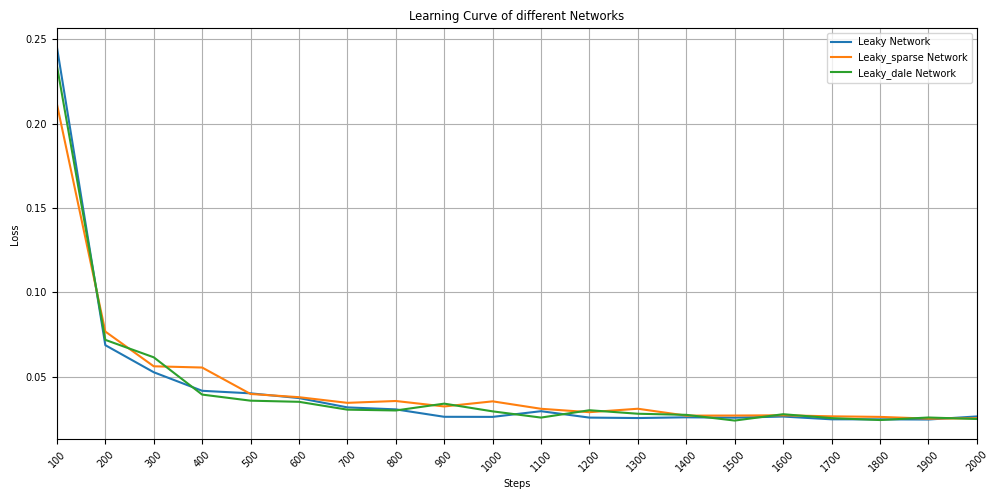

For standard leaky RNN
Trial  0 {'ground_truth': 0, 'coh': 0.0, 'correct': True}
Trial  1 {'ground_truth': 0, 'coh': 12.8, 'correct': True}
Trial  2 {'ground_truth': 1, 'coh': 0.0, 'correct': False}
Trial  3 {'ground_truth': 1, 'coh': 51.2, 'correct': True}
Trial  4 {'ground_truth': 1, 'coh': 12.8, 'correct': True}
Average performance 0.88
For sparse leaky RNN
Trial  0 {'ground_truth': 0, 'coh': 0.0, 'correct': True}
Trial  1 {'ground_truth': 0, 'coh': 12.8, 'correct': True}
Trial  2 {'ground_truth': 1, 'coh': 0.0, 'correct': False}
Trial  3 {'ground_truth': 1, 'coh': 51.2, 'correct': True}
Trial  4 {'ground_truth': 1, 'coh': 12.8, 'correct': True}
Average performance 0.88
For leaky RNN following Dales law
Trial  0 {'ground_truth': 0, 'coh': 0.0, 'correct': True}
Trial  1 {'ground_truth': 0, 'coh': 12.8, 'correct': True}
Trial  2 {'ground_truth': 1, 'coh': 0.0, 'correct': False}
Trial  3 {'ground_truth': 1, 'coh': 51.2, 'correct': True}
Trial  4 {'ground_truth': 1, 'coh': 12.8, 'correc

In [54]:
#@title Plotting the learning curves
# Set the default font to a safer option (like DejaVu Sans)
plt.rcParams['font.family'] = 'DejaVu Sans'

# Plotting the learning curve
plt.figure(figsize=(10,5))
for name, loss_values in loss_dict.items():
  steps = np.arange(100, 100 * (len(loss_values) + 1), 100)
  plt.plot(steps, loss_values, label=f'{name} Network')
plt.title("Learning Curve of different Networks")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.xticks(steps, rotation=45)
plt.xlim(steps[0], steps[-1])
plt.tight_layout()

plt.show()


# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
activity_dict_sparse = {}  # recording activity
activity_dict_dale = {}  # recording activity
trial_infos = {}  # recording trial information
trial_infos_sparse = {}  # recording trial information
trial_infos_dale = {}  # recording trial information

num_trial = 200
stim_activity = [[], []]  # response for ground-truth 0 and 1
stim_activity_sparse = [[], []]  # response for ground-truth 0 and 1
stim_activity_dale = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = net(inputs)
    action_pred_sparse, rnn_activity_sparse = net_sparse(inputs)
    action_pred_dale, rnn_activity_dale = net_dale(inputs)

    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    action_pred_sparse = action_pred_sparse.detach().numpy()[:, 0, :]
    action_pred_dale = action_pred_dale.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    choice_sparse = np.argmax(action_pred_sparse[-1, :])
    choice_dale = np.argmax(action_pred_dale[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]
    correct_sparse = choice_sparse == gt[-1]
    correct_dale = choice_dale == gt[-1]

    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    rnn_activity_sparse = rnn_activity_sparse[:, 0, :].detach().numpy()
    rnn_activity_dale = rnn_activity_dale[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    activity_dict_sparse[i] = rnn_activity_sparse
    activity_dict_dale[i] = rnn_activity_dale
    trial_infos[i] = trial_info  # trial_info is a dictionary
    trial_infos[i].update({'correct': correct})
    trial_infos_sparse[i] = trial_info  # trial_info is a dictionary
    trial_infos_sparse[i].update({'correct': correct_sparse})
    trial_infos_dale[i] = trial_info  # trial_info is a dictionary
    trial_infos_dale[i].update({'correct': correct_dale})
    stim_activity[env.trial['ground_truth']].append(rnn_activity)
    stim_activity_sparse[env.trial['ground_truth']].append(rnn_activity_sparse)
    stim_activity_dale[env.trial['ground_truth']].append(rnn_activity_dale)

# Print information for sample trials standard
print('For standard leaky RNN')
for i in range(5):
    print('Trial ', i, trial_infos[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

# Print information for sample trials sparse
print('For sparse leaky RNN')
for i in range(5):
    print('Trial ', i, trial_infos_sparse[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos_sparse.values()]))

# Print information for sample trials
print('For leaky RNN following Dales law')
for i in range(5):
    print('Trial ', i, trial_infos_dale[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos_dale.values()]))

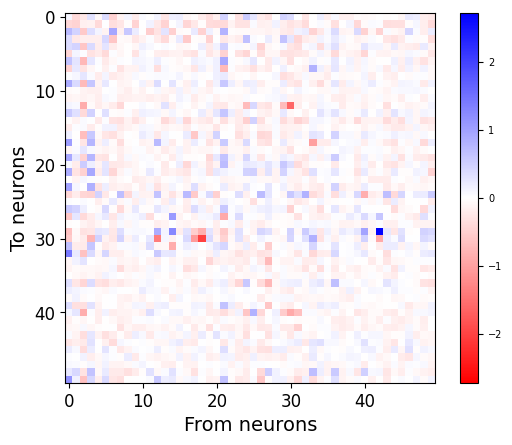

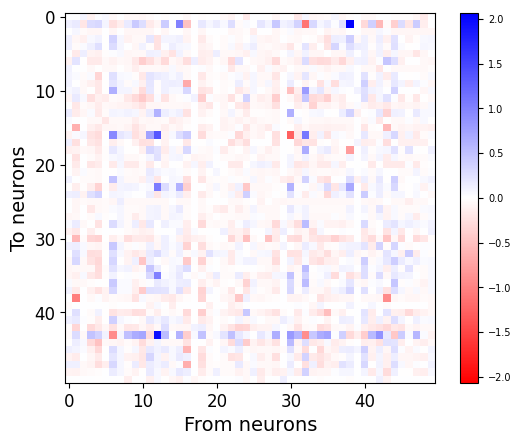

In [58]:
# @title Compute stimulus selectivity for sorting neurons

# Here for each neuron we compute its stimulus period selectivity

mean_activity = []
mean_activity_sparse = []
std_activity = []
std_activity_sparse = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    activity_sparse = np.concatenate(stim_activity_sparse[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    mean_activity_sparse.append(np.mean(activity_sparse, axis=0))
    std_activity.append(np.std(activity, axis=0))
    std_activity_sparse.append(np.std(activity_sparse, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity_sparse = (mean_activity_sparse[0] - mean_activity_sparse[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

# Sort index for selectivity
ind_sort = np.argsort(selectivity)
ind_sort_sparse = np.argsort(selectivity_sparse)

W = net.rnn.h2h.weight.detach().numpy()
W_sparse = net_sparse.rnn.h2h.weight.detach().numpy()
# Sort by selectivity
#W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons', fontsize=14)  # Adjust fontsize for x-axis label
plt.ylabel('To neurons', fontsize=14)    # Adjust fontsize for y-axis label
plt.tick_params(axis='both', which='major', labelsize=12)  # Tick label size

wlim_sparse = np.max(np.abs(W_sparse))
plt.figure()
plt.imshow(W_sparse, cmap='bwr_r', vmin=-wlim_sparse, vmax=wlim_sparse)
plt.colorbar()
plt.xlabel('From neurons', fontsize=14)  # Adjust fontsize for x-axis label
plt.ylabel('To neurons', fontsize=14)    # Adjust fontsize for y-axis label
plt.tick_params(axis='both', which='major', labelsize=12)  # Tick label size


Shape of the neural activity (Time points, Neurons): (12000, 128)
Shape of the neural activity (Time points, Neurons): (12000, 128)
Shape of the neural activity (Time points, Neurons): (12000, 128)
Shape of the projected activity for standard leaky RNN (Time points, PCs): (12000, 2)
Shape of the projected activity for sparse leaky RNN (Time points, PCs): (12000, 2)
Shape of the projected activity for leaky RNN following dales law (Time points, PCs): (12000, 2)


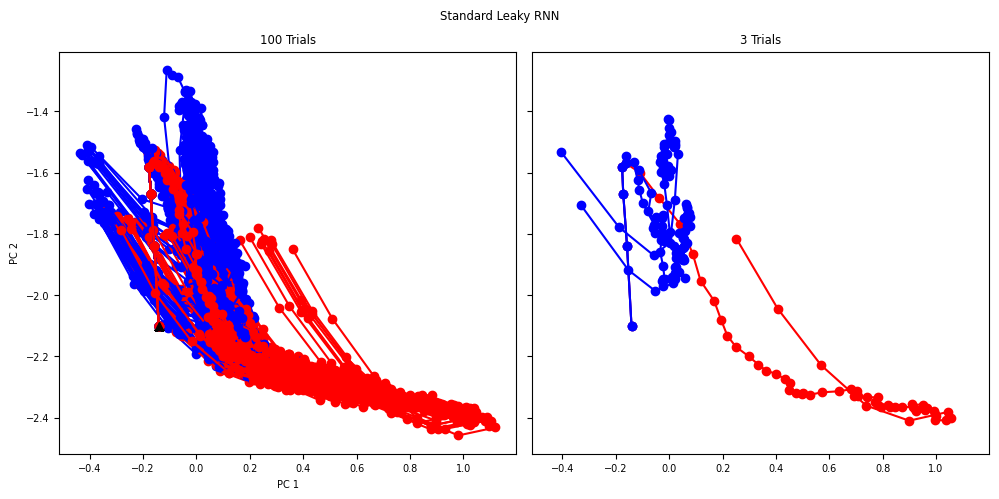

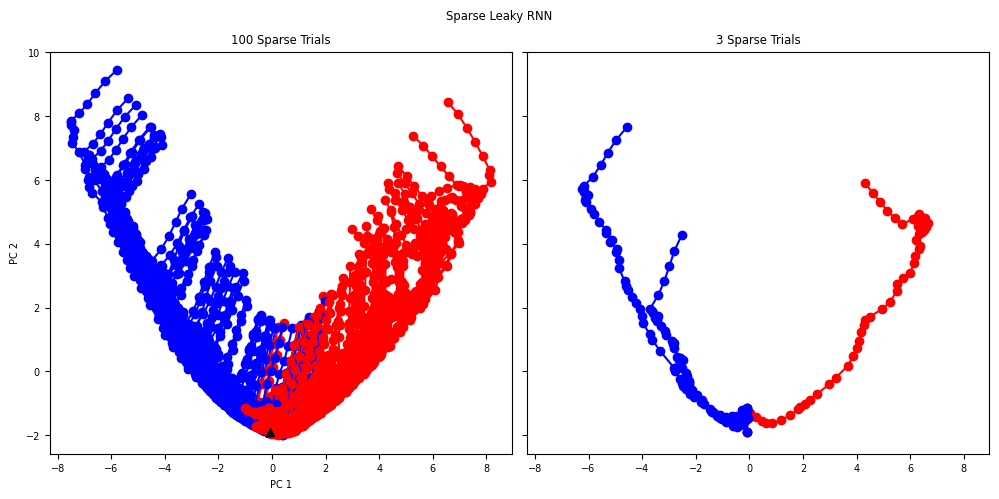

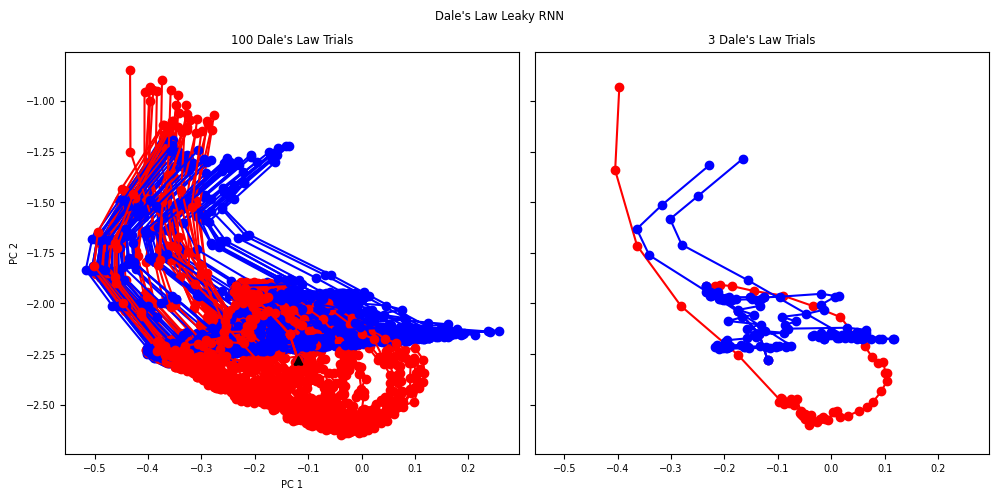

In [15]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = len(activity_dict)  # Number of trials to analyse

### Play with different values here to understand the dynamics
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)
activity_sparse = np.concatenate([activity_dict_sparse[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity_sparse.shape)
activity_dale = np.concatenate([activity_dict_sparse[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity_dale.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
pca.fit(activity_sparse)
pca.fit(activity_dale)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)
activity_pc_sparse = pca.transform(activity_sparse)  # Transform to lower dimensions (2D)
activity_pc_dale = pca.transform(activity_dale)  # Transform to lower dimensions (2D)
print('Shape of the projected activity for standard leaky RNN (Time points, PCs):', activity_pc.shape)
print('Shape of the projected activity for sparse leaky RNN (Time points, PCs):', activity_pc_sparse.shape)
print('Shape of the projected activity for leaky RNN following dales law (Time points, PCs):', activity_pc_dale.shape)

# Visualization
import matplotlib.pyplot as plt

def plot_trials(activity_dict, trial_infos, plot_until_time, title, ax1_title, ax2_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

    # Plot all trials in ax1 and fewer trials in ax2 for clarity
    for i in range(100):
        # Transform and plot each trial
        activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

        # Color by ground truth
        trial = trial_infos[i]
        color = 'red' if trial['ground_truth'] == 0 else 'blue'

        ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
        if i < 3:  # Fewer trials in ax2 for clear visualization
            ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

        # Indicate trial start with a different marker
        ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

    # Setting labels and titles for clarity
    ax1.set_title(ax1_title)
    ax2.set_title(ax2_title)
    ax1.set_xlabel('PC 1')
    ax1.set_ylabel('PC 2')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Plot for standard leaky RNN
plot_trials(activity_dict=activity_dict, trial_infos=trial_infos, plot_until_time=plot_until_time,
    title="Standard Leaky RNN", ax1_title="100 Trials", ax2_title="3 Trials")

# Plot for sparse leaky RNN
plot_trials(activity_dict=activity_dict_sparse, trial_infos=trial_infos, plot_until_time=plot_until_time,
    title="Sparse Leaky RNN", ax1_title="100 Sparse Trials", ax2_title="3 Sparse Trials")

# Plot for Dale's law leaky RNN
plot_trials(
    activity_dict=activity_dict_dale,
    trial_infos=trial_infos,
    plot_until_time=plot_until_time,
    title="Dale's Law Leaky RNN",
    ax1_title="100 Dale's Law Trials",
    ax2_title="3 Dale's Law Trials"
)


In [ ]:
# Path to the uploaded file
!unzip /content/fixed-point-finder-master.zip -d /content/

# Navigate to the extracted directory
%cd /content/fixed-point-finder-master
ikit-learn==1.2.2 matplotlib==3.7.1 torch==1.12.1


SyntaxError: invalid syntax (<ipython-input-13-331daff2d331>, line 6)

In [ ]:
# Add the path to the directory containing FixedPointFinderTorch.py
import sys
sys.path.append('/content/fixed-point-finder-master')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
# Now you can create an instance of FixedPointFinderTorch with your RNN


In [ ]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

In [ ]:
# Instantiate the FixedPointRNNWrapper with the model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(net.rnn, batch_first=False)
rnn_model_fixed_point_sparse = FixedPointRNNWrapper(net_sparse.rnn, batch_first=False)
rnn_model_fixed_point_dale = FixedPointRNNWrapper(net_dale.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped models
finder = FixedPointFinder(rnn_model_fixed_point)
finder_sparse = FixedPointFinder(rnn_model_fixed_point_sparse)
finder_dale = FixedPointFinder(rnn_model_fixed_point_dale)


# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, net.rnn.hidden_size)  # 10 random initial hidden states (one for each hidden unit)
initial_conditions_sparse = torch.randn(10, net_sparse.rnn.hidden_size)  # 10 random initial hidden states (one for each hidden unit)
initial_conditions_dale = torch.randn(10, net_dale.rnn.hidden_size)  # 10 random initial hidden states (one for each hidden unit)
inputs = torch.zeros(10, net.input_size)  # Zero input for each initial condition
inputs_sparse = torch.zeros(10, net_sparse.input_size)  # Zero input for each initial condition
inputs_dale = torch.zeros(10, net_dale.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
init_hidden_np_sparse = initial_conditions_sparse.cpu().numpy()
init_hidden_np_dale = initial_conditions_dale.cpu().numpy()
inputs_np = inputs.cpu().numpy()
inputs_np_sparse = inputs_sparse.cpu().numpy()
inputs_np_dale = inputs_dale.cpu().numpy()

# Find fixed points (Check FixedPointFinder documentation)
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
fixed_points_result_sparse = finder.find_fixed_points(initial_states=init_hidden_np_sparse, inputs=inputs_np_sparse)
fixed_points_result_dale = finder.find_fixed_points(initial_states=init_hidden_np_dale, inputs=inputs_np_dale)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element
fps_sparse = fixed_points_result_sparse[0]  # Assuming FixedPoints object is the first element
fps_dale = fixed_points_result_dale[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute
fixed_points_sparse = fps_sparse.xstar  # Now you can access the xstar attribute
fixed_points_dale = fps_dale.xstar  # Now you can access the xstar attribute


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		1343 iters
		q = 1.95e-13 +/- 2.92e-13
		dq = 2.10e-14 +/- 1.83e-14
		learning rate = 1.22e-01
		avg iter time = 1.17e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		2660 iters
		q = 1.51e-13 +/- 3.10e-13
		dq = 8.33e-15 +/- 7.07e-15
		learning

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


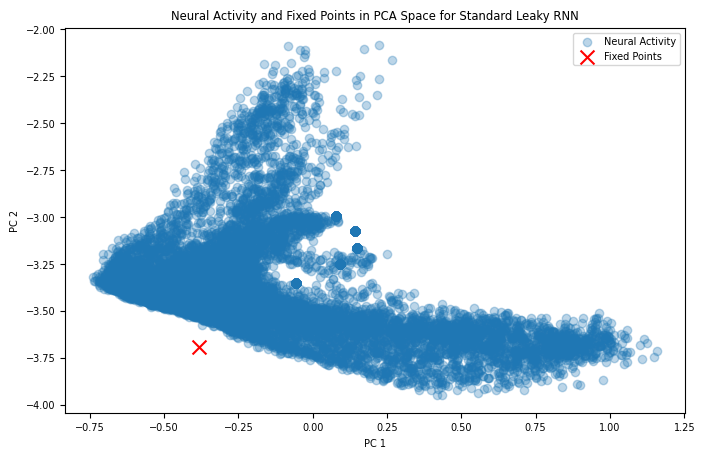

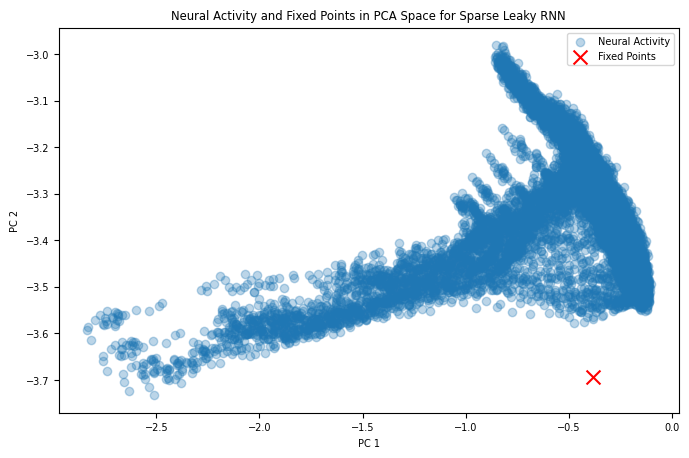

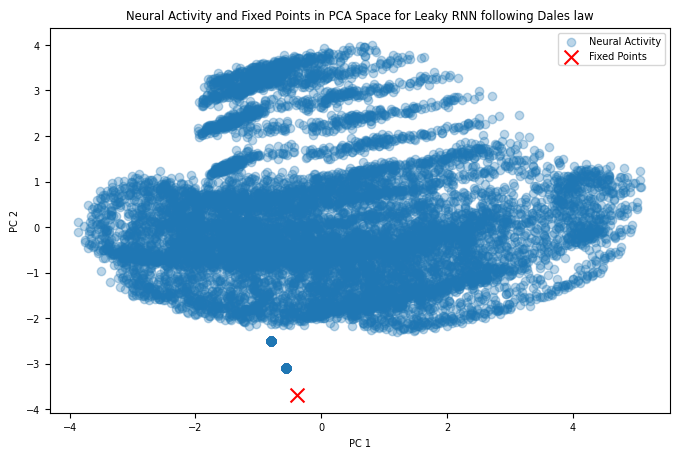

In [ ]:
# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]activity_list = []

activity_list_sparse = []
for trial_activity_sparse in activity_dict_sparse.values():
    activity_list_sparse.append(trial_activity_sparse)  # Each trial_activity is of shape [time_steps, hidden_size]
activity_sparse = np.vstack(activity_list_sparse)  # Concatenate along the time axis to get [total_time_steps, hidden_size]activity_list = []

activity_list_dale = []
for trial_activity_dale in activity_dict_dale.values():
    activity_list_dale.append(trial_activity_dale)  # Each trial_activity is of shape [time_steps, hidden_size]
activity_dale = np.vstack(activity_list_dale)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]
fixed_points_array_sparse = np.vstack(fixed_points_sparse)  # Shape: [num_fixed_points, hidden_size]
fixed_points_array_dale = np.vstack(fixed_points_dale)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
activity_and_fp_sparse = np.concatenate([activity_sparse, fixed_points_array_sparse], axis=0)
activity_and_fp_dale = np.concatenate([activity_dale, fixed_points_array_dale], axis=0)
pca.fit(activity_and_fp)
pca.fit(activity_and_fp_sparse)
pca.fit(activity_and_fp_dale)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
activity_pc_sparse = pca.transform(activity_sparse)
activity_pc_dale = pca.transform(activity_dale)
fixed_points_pc = pca.transform(fixed_points_array)
fixed_points_pc_sparse = pca.transform(fixed_points_array_sparse)
fixed_points_pc_dale = pca.transform(fixed_points_array_dale)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space for Standard Leaky RNN")
plt.legend()
plt.show()# Plot activity and fixed points

plt.figure(figsize=(8, 5))
plt.scatter(activity_pc_sparse[:, 0], activity_pc_sparse[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc_sparse[:, 0], fixed_points_pc_sparse[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space for Sparse Leaky RNN")
plt.legend()
plt.show()# Plot activity and fixed points

plt.figure(figsize=(8, 5))
plt.scatter(activity_pc_dale[:, 0], activity_pc_dale[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc_dale[:, 0], fixed_points_pc_dale[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space for Leaky RNN following Dales law")
plt.legend()
plt.show()
